In [30]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import camb
from camb import model, initialpower
from camb.sources import GaussianSourceWindow, SplinedSourceWindow
import numpy as np
import sympy as sy
from sympy import symbols
from scipy import interpolate
from scipy import optimize
import matplotlib
from matplotlib import pyplot as plt
import ngfunction

In [31]:
##PARAMETRI INIZIALI

pars = camb.CAMBparams()  #0.022 0.122 67.5
pars.set_cosmology(H0=73, ombh2=0.023, omch2=0.111)   #H0= hubble parameter today in km/s    ombh2=physical density in baryons omch2=physical density in cold dark matter
#trovo densità diverse...
pars.InitPower.set_params(ns=0.965)  #ns = scalar spectra index (inflaction)


class: <InitialPowerLaw>
 tensor_parameterization = tensor_param_rpivot
 ns = 0.965
 nrun = 0.0
 nrunrun = 0.0
 nt = -0.0
 ntrun = -0.0
 r = 0.0
 pivot_scalar = 0.05
 pivot_tensor = 0.05
 As = 2e-09
 At = 1.0
 

In [32]:
pars.set_matter_power(redshifts=[0.7], kmax=3.0)  
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)   

In [33]:
def dist(z):   #funzione per trasformare il redshift in distanza
    return results.comoving_radial_distance(z) #coefficiente per trasformare il redshift in un raggio, c/H0 = [km/s  / (km/s)/Mpc] = [Mpc], z è adimensionale


In [34]:
kh, z, pk = results.get_matter_power_spectrum(minkh=1e-2, maxkh=1e-1, npoints = 100) #nota, le z vengono ordinate, ricavo spettro di potenza

In [35]:
H0 = results.hubble_parameter(0)    #parametri di hubble
h = H0/100
def H(z):
    return results.hubble_parameter(z)

kh = kh/h  #H0 = 70km/(s*Mpc) h=0.7 ma non era senza unità di misura?
pk = pk*h**3

In [36]:
bias = 1 + z[0]*0.84   #funzione di bias delle galassie, cercane altre!!
f = (results.get_fsigma8()/results.get_sigma8())
 #la calcola alla z scelta già, UNITà DI MISURA

mu = np.arange(-1,1,0.1)      #range di valori dell'angolo
N = len(kh)*len(mu)   #numero di dati simulati

In [37]:
#Set di dati simulati spettro di potenza delle galassie

Pgg = np.empty((len(kh),len(mu)))
for i in range (len(kh)):
    for j in range (len(mu)):
        Pgg[i][j] = ( float(np.power(bias + f * np.power(mu[j],2),2)*pk[:,i]))


In [38]:
#Dati per la funzione teorica
#om=(0.134)/(h**2)  #PRESO DA QUELLE INIZIALI MA NON TORNANO COI DATI, ho usato una h diversa
#omb= 0.31  # densità di materia per z=0, presa da libro
om = results.get_Omega('cdm',0) + results.get_Omega('baryon',0)    #densità di materia nell'universo
omz= om*(1+z[0])**3/(H(z[0])/H0)**2 #densità di materia a diverso z
omz

0.6210583881231838

In [39]:
print(f)
print(omz**0.545)

[0.77329033]
0.7713601086994607


In [40]:
##Errori dei dati simulati
ng= ngfunction.Ng(z[0])*10**4/h**3   #mean galaxy number density for z near 0 (Euclid spettroscopy survey)
DeltaMu = np.abs(mu[0]-mu[1])
DeltaZ = 0.1
DeltaK = np.empty((len(kh)))

for i in range (len (kh)):
    if i==0 : DeltaK[i]= 2*np.abs(kh[i+1]-kh[i])
    elif i==len(kh)-1:
       DeltaK[i]= 2*np.abs(kh[i-1]-kh[i])
    else: DeltaK[i]= np.abs(kh[i+1]-kh[i])/2+ np.abs(kh[i-1]-kh[i])/2
    if(DeltaK[i]<1e-2): DeltaK[i]=1e-2   #l'intervallo deve comunque essere più grande di kmin, se non lo è lo metto uguale a kmin
    
N = np.empty((len(kh),len(mu)))
Vol = 4./3.*np.pi*((dist(z[0]+DeltaZ/2))**3-(dist(z[0]-DeltaZ/2)**3))    #calcolo il volume di cielo considerato, inmmagino di guardare il cielo su tutti gli angoli (ideale)

for j in range(len(kh)):
    N[j,:]= Vol/(2*np.pi)**3 * kh[j]**2*DeltaMu*DeltaK[j]  #uguale per tutte le mu

err_Pgg = np.empty((len(kh),len(mu)))
for i in range (len(kh)):
    for j in range (len(mu)):
        err_Pgg[i][j] = np.sqrt(2/N[i][j])*(Pgg[i][j]+1/ng)




In [41]:
#cerco la distanza minima, per risalire il kmin da mettere all'inizio del codice

kmin= 2*np.pi/(dist(z[0]+DeltaZ/2)-dist(z[0]-DeltaZ/2))
kmin*h

0.015750493585308428

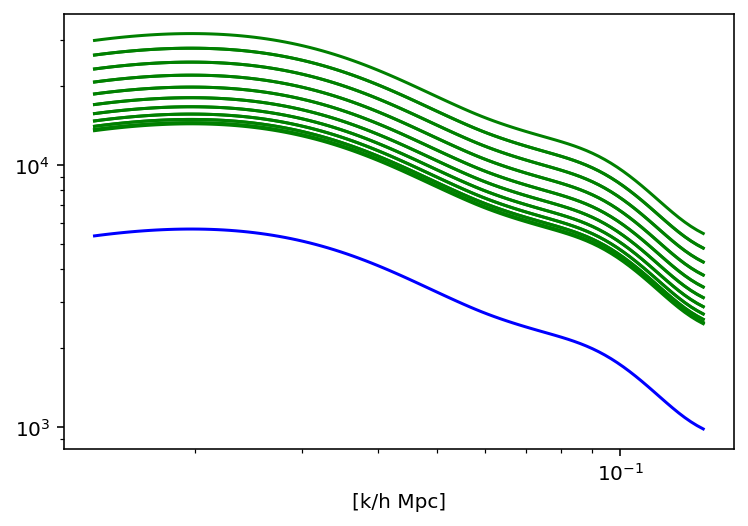

In [42]:
#Grafico

fit, ax = plt.subplots()

ax.set_xlabel('[k/h Mpc]')
ax.set_xscale('log')
ax.set_yscale('log')

ax.plot(kh, pk[0,:], color='b', ls = '-')
for i in range(len(mu)):
    ax.plot(kh, Pgg[:,i], color='g', ls ='-')  #aggiungi gli errori

#ax.legend(['matter','galaxy'], loc='lower left')
#plt.title('Total Matter power at z=%s and z= %s'%tuple(z));

[10338.46271402 10171.35355631 10003.18281558  9834.00036995
  9663.86064976  9492.81326897  9320.90476215  9148.18744859
  8974.71957126  8800.56132311  8625.7721477   8450.41712044
  8274.56747231  8098.29801496  7921.68098835  7744.79312471
  7567.71744973  7390.54228266  7213.35613032  7036.25081611
  6859.32399413  6682.67870956  6506.42157908  6330.66261608
  6155.51627086  5981.1010346   5807.5407572   5634.96546032
  5463.50739968  5293.30012707  5124.48105959  4957.19937701
  4791.60481308  4627.84389977  4466.0619339   4306.42050974
  4149.08372307  3994.20596814  3841.93267113  3692.42285483
  3545.84498058  3402.35066403  3262.07402129  3125.15306707
  2991.74675145  2861.99225535  2736.0007407   2613.86934131
  2495.71337235  2381.62826247  2271.67895197  2165.90812421
  2064.38351543  1967.16701596  1874.28605624  1785.73669219
  1701.46990281  1621.39789352  1545.41931811  1473.42298208
  1405.32573566  1341.10717091  1280.73299541  1224.14826632
  1171.21835477  1121.63

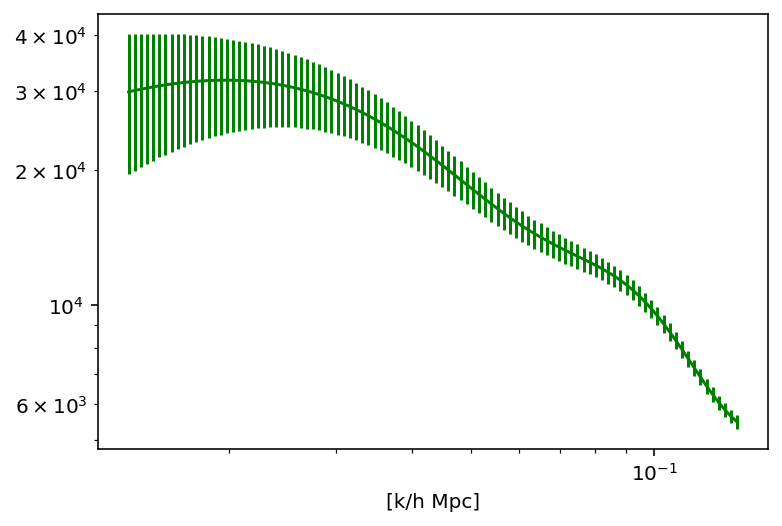

In [43]:
fit, ax = plt.subplots()

ax.set_xlabel('[k/h Mpc]')
ax.set_xscale('log')
ax.set_yscale('log')

ax.errorbar(kh, Pgg[:,0], yerr = err_Pgg[:,0], color='g', ls ='-')  #aggiungi gli errori
print(err_Pgg[:,0])


In [58]:
gammas= np.arange(0.4,0.6,0.005)   #calcolo il chi quadro per un certo set di valori di gamma

for k in range(len(gammas)):
    gammas[k] = round (gammas[k],3)

chi2 = np.zeros(len(gammas))


for k,gamma in enumerate(gammas):
    for i in range (len(kh)):
        for j in range (len(mu)):
            chi2[k]= chi2[k]+(float((bias + (omz**gamma) * (mu[j])**2)**2*pk[:,i]) - Pgg[i][j])**2/err_Pgg[i][j]**2
        



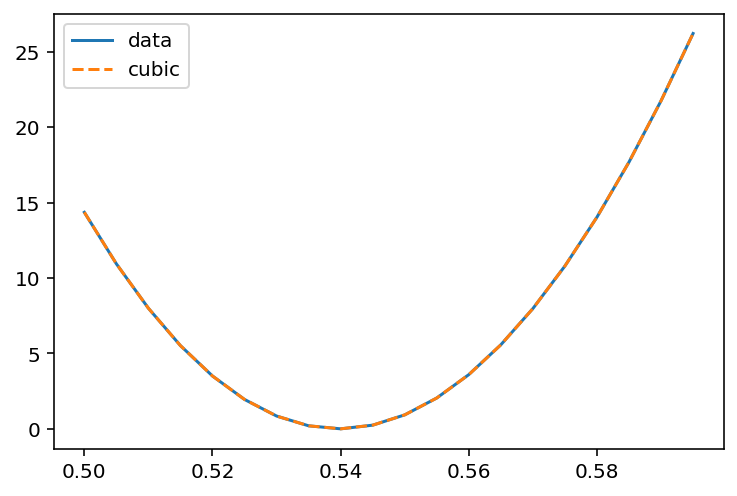

In [59]:
#INTERPOLAZIONE FUNZIONE CHI^2
interpol =  interpolate.interp1d(gammas,chi2,kind='cubic')
plt.plot(gammas,chi2,'-', gammas, interpol(gammas), '--')
plt.legend(['data', 'cubic'])


#plt.axis([0.54,0.56,0,0.4e9])

In [46]:
type(interpol)
y=lambda x: interpol(x)


In [47]:

minimo = optimize.least_squares(y,0.53)
min1= float(minimo.x)
minimo

 active_mask: array([0.])
        cost: 1.2341457496380926e-15
         fun: array([4.96819031e-08])
        grad: array([-2.13654133e-09])
         jac: array([[-0.04300442]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 13
        njev: 13
  optimality: 2.1365413307543615e-09
      status: 1
     success: True
           x: array([0.53975071])

In [48]:
chi2min= y(min1)

In [49]:
min2= np.min(chi2)      #trova un valore minimo di chi2, solo a livello discreto, meno preciso
index_min = np.argmin(chi2)
gamma_min = gammas[index_min]
gamma_min

0.54

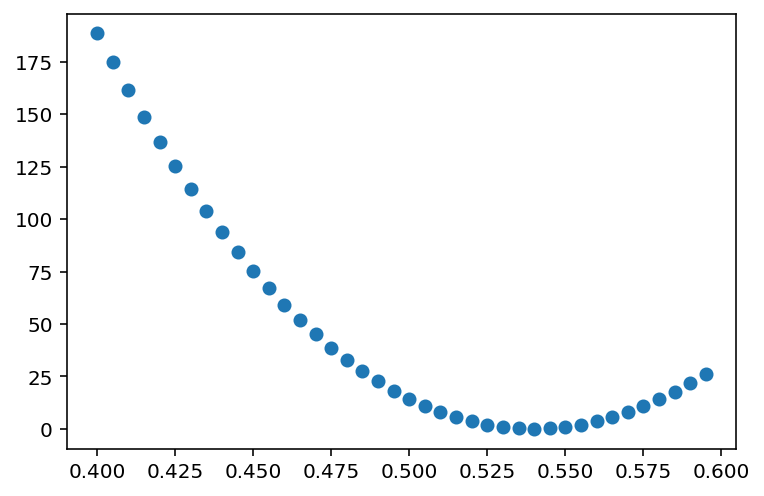

In [50]:
plt.scatter(gammas,chi2)

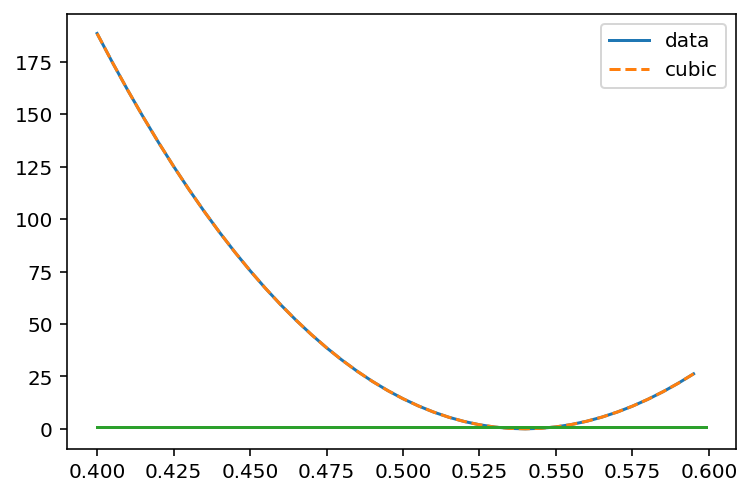

In [51]:
#devo scalare il grafico
plt.plot(gammas,chi2-chi2min,'-', gammas, interpol(gammas)-chi2min, '--')
plt.legend(['data', 'cubic'])

#CALCOLO DELL'ERRORE
xpoints= np.arange(0.4,0.6,0.001)
ypoints = np.ones(len(xpoints))
plt.plot(xpoints,ypoints)



In [52]:
y2= lambda x: interpol(x) - 1 -chi2min
error1 = optimize.brentq(y2,0.45,min1)    #trova le soluzioni in un intervallo fissato
error2 = optimize.brentq(y2,min1,0.57)
print(error1,error2)

0.5291711938673849 0.5504019217125499


In [53]:
print(np.abs(min1-error1))
print(np.abs(min1-error2))

sigma = 0.006

0.010579519108621982
0.010651208736543016


In [54]:
print("Il valore di gamma trovato è: ", round(min1,3) ," +- ", sigma)

Il valore di gamma trovato è:  0.54  +-  0.006


In [55]:
#facciamo il fit, posso usare optimize perché ho l'errore su una sola variabile

#def func(i, gamma):
#    return (bias + (omz**gamma) * (mu[j])**2)**2*pk[:,i]
#
#index = np.array(0,len(kh),1)
#popt, pcov = optimize.curve_fit(func, index , Pgg[:,?], err_Pgg)  #non so che fare con ste mu


In [56]:
interpol1 = interpol

In [57]:
interpol1(0.4)

array(188.4652177)